In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training

BATCH_SIZE = 64

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("/fastdata/test/train/")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

/home/nick/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Empty         7081
Compacting    3565
Blast         2550
2pn           2326
4 Cell        1667
Syngamy       1546
2 Cell        1511
6-7 Cell       953
8 Cell         808
9+ Cell        710
3 Cell         476
5 Cell         425
Name: class, dtype: int64

<AxesSubplot:>

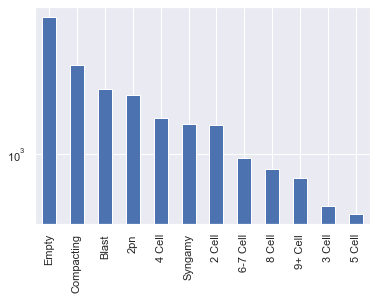

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [4]:
class_counts = df["class"].value_counts()
#mask = ~df["class"].isin(class_counts[class_counts > 10].index)
#df["class"][mask] = "Other"

In [7]:
#df["class"][~df["class"].isin(["Empty", "Morula"])] = "Other"
# Build training and validation dataframes. This gives us fine control over what we use for train & test
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    if len(df_for_class) > 20:
        validation_sample = df_for_class.sample(min(round(.2*len(df_for_class)),700))
        validation_rows.append(validation_sample)
        train_sample = df_for_class.drop(validation_sample.index)
        # Accounting for training class imbalance
        # still leaving 20%. Might need more sophisticated f(x) here for class imbalance.
        train_sample = train_sample.sample(min(len(train_sample), round(len(df_for_class)),3000))
        train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,/fastdata/test/train/Blast/M3171_S00629_W8_F0_6858.jpg,Blast
1,/fastdata/test/train/Blast/M0776_S00512_W5_F0_6661.jpg,Blast
2,/fastdata/test/train/Blast/M0831_S00479_W1_F0_6923.jpg,Blast
3,/fastdata/test/train/Blast/M0831_S00534_W12_F0_6875.jpg,Blast
4,/fastdata/test/train/Blast/M3171_S00629_W5_F0_6942.jpg,Blast
...,...,...
2321,/fastdata/test/train/2pn/M0831_S00470_W5_F0_827.jpg,2pn
2322,/fastdata/test/train/2pn/M0831_S00493_W6_F0_526.jpg,2pn
2323,/fastdata/test/train/2pn/M0831_S00534_W12_F0_520.jpg,2pn
2324,/fastdata/test/train/2pn/M0831_S00635_W2_F0_867.jpg,2pn


Empty         3000
Compacting    2865
Blast         2040
2pn           1861
4 Cell        1334
Syngamy       1237
2 Cell        1209
6-7 Cell       762
8 Cell         646
9+ Cell        568
3 Cell         381
5 Cell         340
Name: class, dtype: int64

Empty         700
Compacting    700
Blast         510
2pn           465
4 Cell        333
Syngamy       309
2 Cell        302
6-7 Cell      191
8 Cell        162
9+ Cell       142
3 Cell         95
5 Cell         85
Name: class, dtype: int64

In [8]:

datagen = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
)


training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=True)

# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)

Found 16243 validated image filenames belonging to 12 classes.
Found 3994 validated image filenames belonging to 12 classes.


In [9]:
assert training.class_indices == validation.class_indices

In [10]:
list(training.class_indices.keys())

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6-7 Cell',
 '8 Cell',
 '9+ Cell',
 'Blast',
 'Compacting',
 'Empty',
 'Syngamy']

In [11]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: '2 Cell',
 1: '2pn',
 2: '3 Cell',
 3: '4 Cell',
 4: '5 Cell',
 5: '6-7 Cell',
 6: '8 Cell',
 7: '9+ Cell',
 8: 'Blast',
 9: 'Compacting',
 10: 'Empty',
 11: 'Syngamy'}

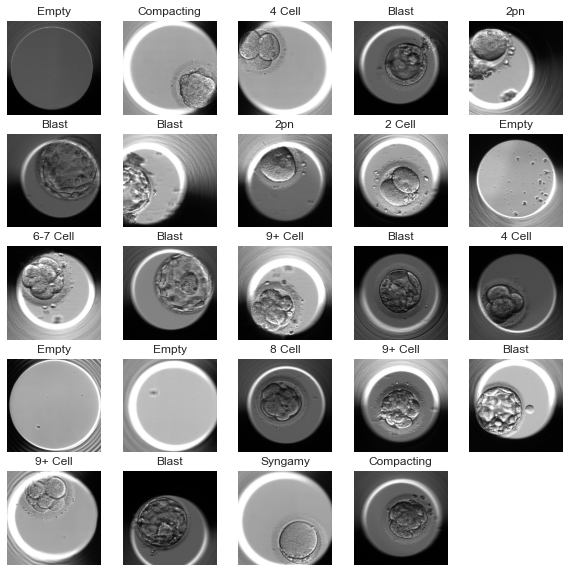

In [12]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i]/255)
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

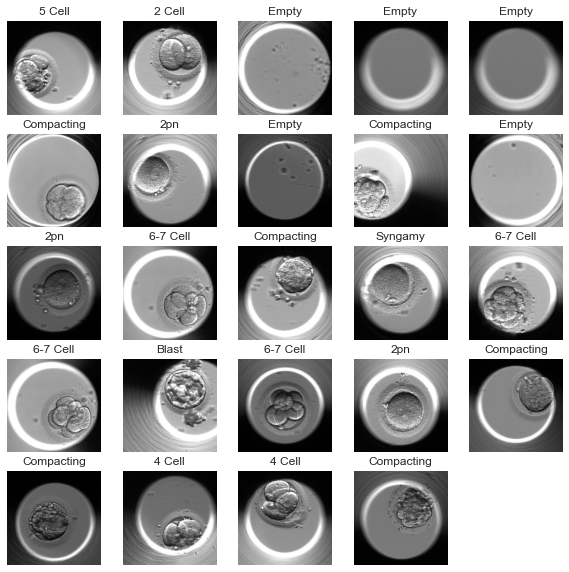

In [13]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i]/255)
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [16]:

base = keras.applications.Xception(
    weights='imagenet',
    input_shape=(299,299,3),
    include_top=False
)
# Freeze the base_model
base.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1./127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation='relu')(x)
#x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(len(code2class), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [17]:
%%time
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[keras.metrics.CategoricalAccuracy()],
)


CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 10.8 ms


In [19]:

history = model.fit(training,
                    epochs=500,
                    verbose=1, # TQDMProgressBar logs out the info, so no need for the default logs
                    validation_data=validation,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=5, verbose=1),
                    ])

Epoch 1/500
254/254 [==============================] - 70s 274ms/step - loss: 0.9325 - categorical_accuracy: 0.8271 - val_loss: 0.8896 - val_categorical_accuracy: 0.8450
Epoch 2/500
254/254 [==============================] - 71s 278ms/step - loss: 0.9101 - categorical_accuracy: 0.8362 - val_loss: 0.8758 - val_categorical_accuracy: 0.8505
Epoch 3/500
254/254 [==============================] - 70s 273ms/step - loss: 0.8751 - categorical_accuracy: 0.8557 - val_loss: 0.8450 - val_categorical_accuracy: 0.8683
Epoch 4/500
254/254 [==============================] - 70s 275ms/step - loss: 0.8567 - categorical_accuracy: 0.8623 - val_loss: 0.8394 - val_categorical_accuracy: 0.8703
Epoch 5/500
254/254 [==============================] - 71s 278ms/step - loss: 0.8477 - categorical_accuracy: 0.8650 - val_loss: 0.8334 - val_categorical_accuracy: 0.8696
Epoch 6/500
254/254 [==============================] - 69s 271ms/step - loss: 0.8305 - categorical_accuracy: 0.8726 - val_loss: 0.8076 - val_categoric

<AxesSubplot:>

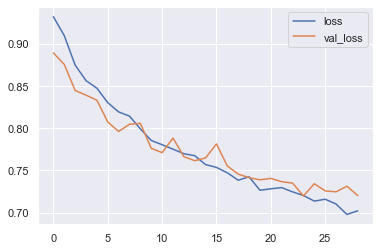

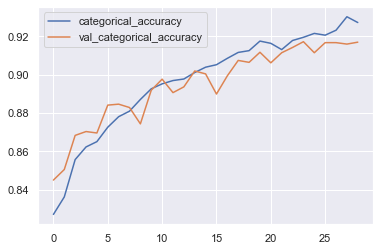

In [20]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [21]:
y_pred = model.predict(validation)

63/63 [==============================] - 14s 218ms/step


In [22]:
predicted_codes = y_pred.argmax(axis=1)
confidence = pd.Series(y_pred.max(axis=1))
confidence.describe()

count    3994.000000
mean        0.832607
std         0.131737
min         0.226779
25%         0.823553
50%         0.876827
75%         0.912458
max         0.987431
dtype: float64

In [23]:
validation_df["predicted_class"] = [code2class[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df
validation_df.to_csv("predictions.csv", index=False)

In [24]:
validation_df.groupby("class").confidence.median()

class
2 Cell        0.880454
2pn           0.876066
3 Cell        0.873965
4 Cell        0.871364
5 Cell        0.871819
6-7 Cell      0.865292
8 Cell        0.875594
9+ Cell       0.877231
Blast         0.876329
Compacting    0.880232
Empty         0.877381
Syngamy       0.876336
Name: confidence, dtype: float32

              precision    recall  f1-score   support

      2 Cell       0.89      0.94      0.92       302
         2pn       0.90      0.95      0.92       465
      3 Cell       0.94      0.53      0.68        95
      4 Cell       0.81      0.94      0.87       333
      5 Cell       0.80      0.61      0.69        85
    6-7 Cell       0.86      0.75      0.80       191
      8 Cell       0.82      0.86      0.84       162
     9+ Cell       0.93      0.80      0.86       142
       Blast       0.97      0.94      0.95       510
  Compacting       0.92      0.96      0.94       700
       Empty       1.00      1.00      1.00       700
     Syngamy       0.93      0.85      0.89       309

    accuracy                           0.92      3994
   macro avg       0.90      0.85      0.86      3994
weighted avg       0.92      0.92      0.91      3994



Text(30.453125, 0.5, 'True')

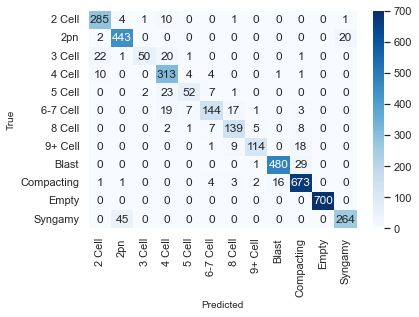

In [25]:
print(classification_report(validation_df["class"], validation_df["predicted_class"]))
labels = list(training.class_indices.keys())
s = sns.heatmap(
    confusion_matrix(validation_df["class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=labels,
    yticklabels=labels
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [27]:
model.save(f"./models/dense_{len(code2class)}_class.h5")